In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import f_oneway
from sklearn.metrics import mean_absolute_error

In [2]:
df = pd.read_csv('StudentPerformanceFactors.csv')

In [3]:
df = df.dropna()
df = df[df['Tutoring_Sessions'] != 8]

In [4]:
categorical_columns = ['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender', 'Sleep_Hours', 'Tutoring_Sessions', 'Physical_Activity']

In [5]:
sum_stats = df['Exam_Score'].describe()

In [6]:
lower_bound = sum_stats['mean'] - 3 * sum_stats['std']
upper_bound = sum_stats['mean'] + 3 * sum_stats['std']

In [7]:
filtered_df = df[(df['Exam_Score'] > lower_bound) & (df['Exam_Score'] < upper_bound)]

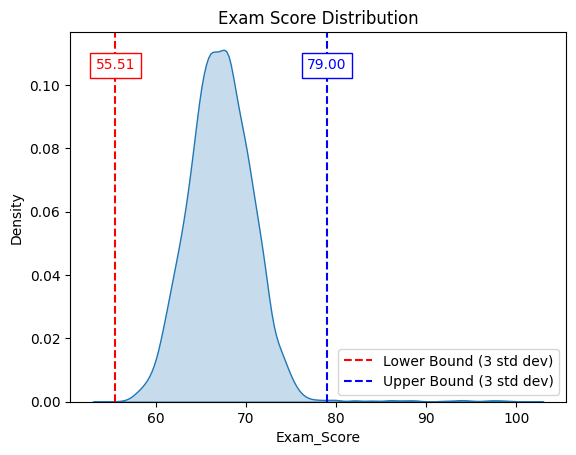

In [8]:
sns.kdeplot(df['Exam_Score'], fill=True)
plt.title('Exam Score Distribution')
plt.axvline(lower_bound, color='red', linestyle='--', label='Lower Bound (3 std dev)')
plt.axvline(upper_bound, color='blue', linestyle='--', label='Upper Bound (3 std dev)')

plt.text(lower_bound, plt.ylim()[1]*0.9, f'{lower_bound:.2f}', color='red', ha='center', bbox=dict(facecolor='white', edgecolor='red'))
plt.text(upper_bound, plt.ylim()[1]*0.9, f'{upper_bound:.2f}', color='blue', ha='center', bbox=dict(facecolor='white', edgecolor='blue'))
plt.legend()



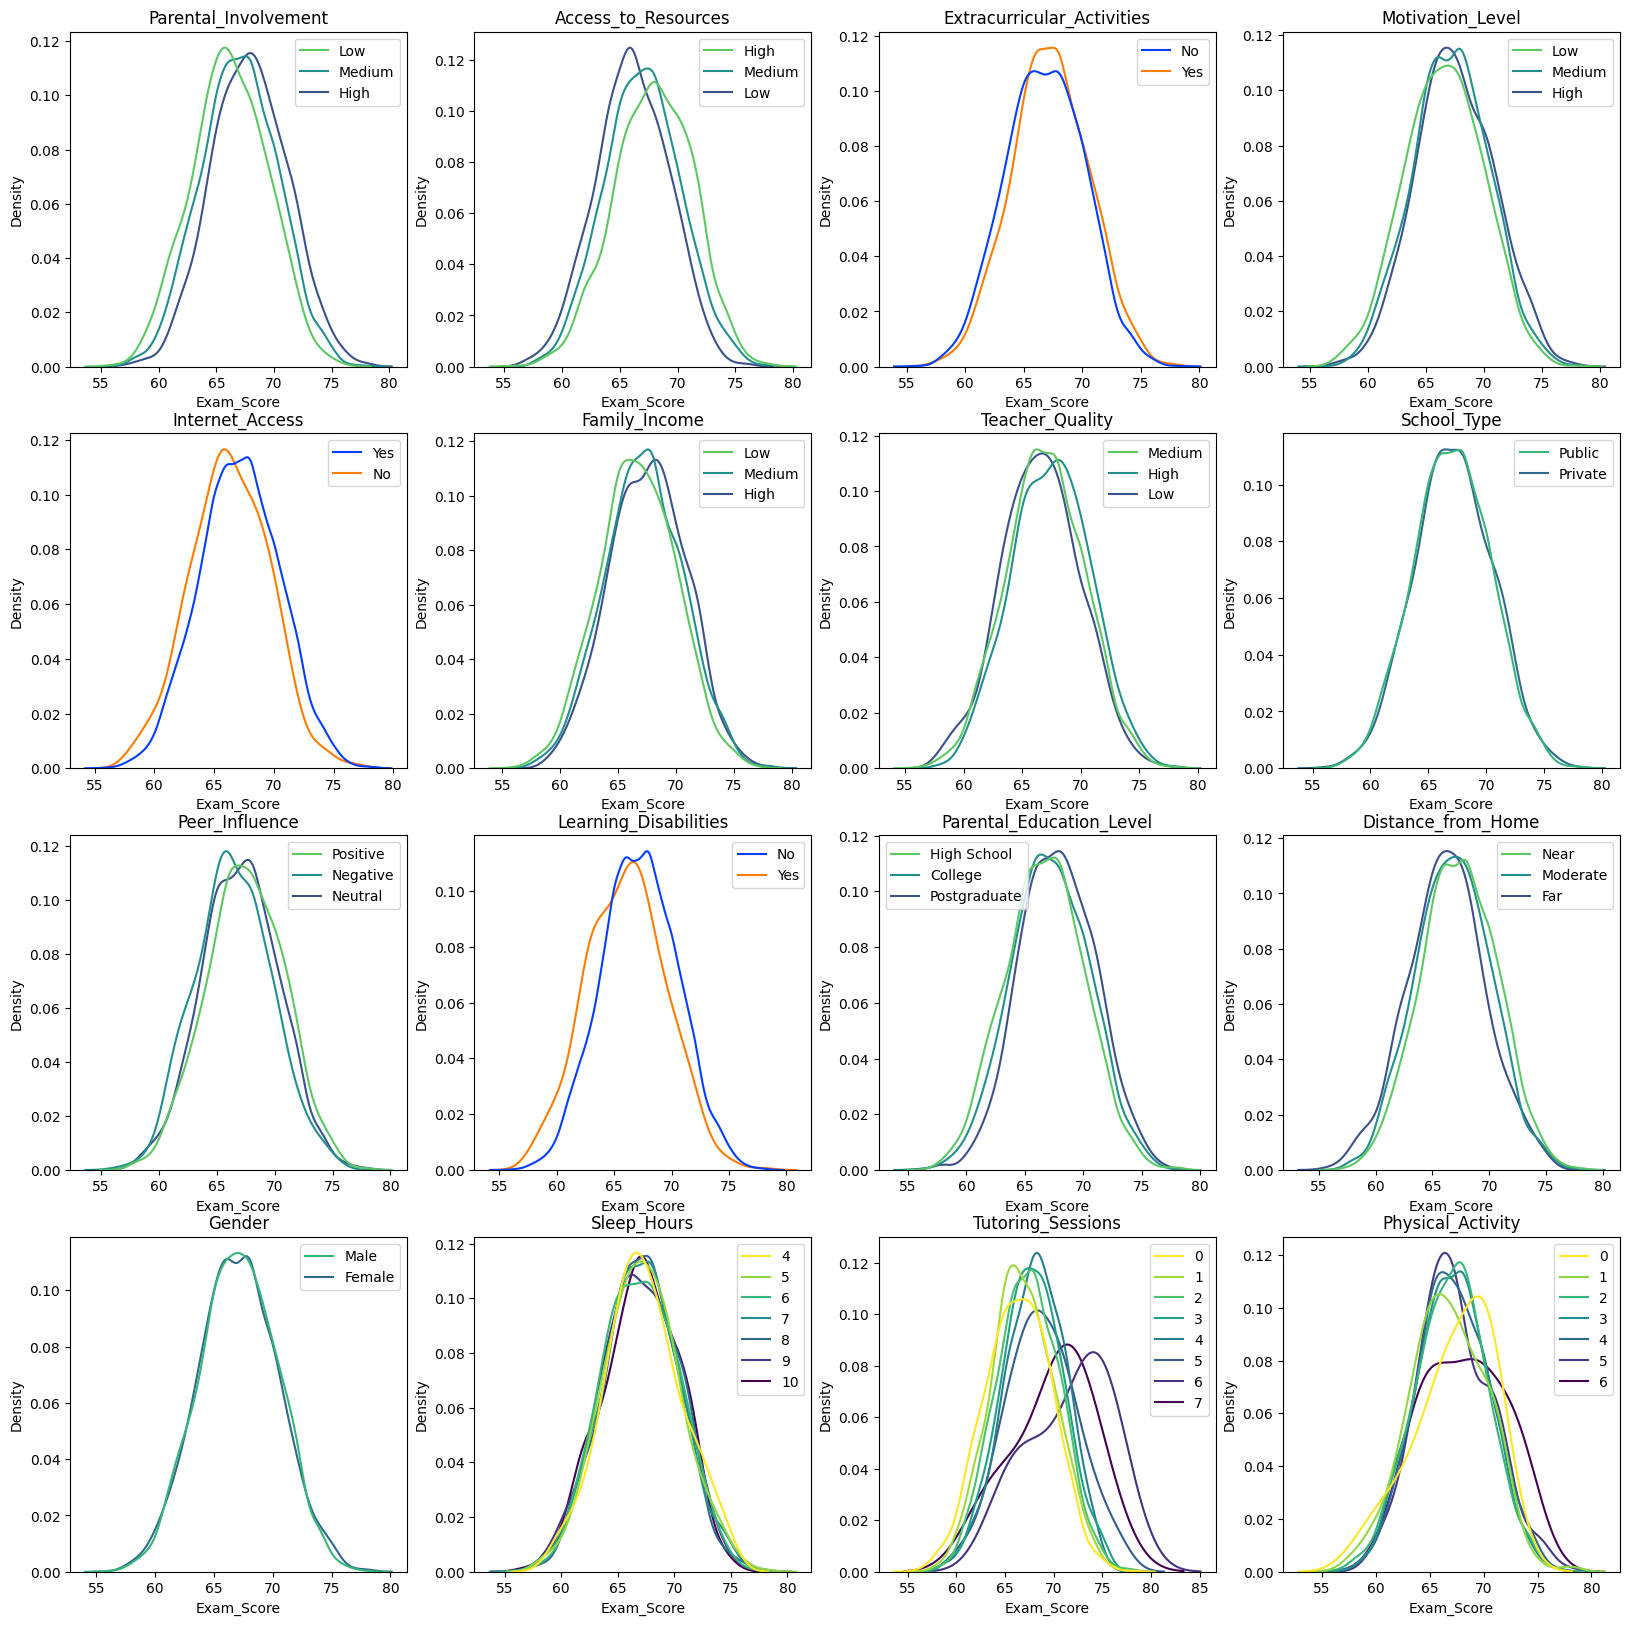

In [9]:
fig, ax = plt.subplots(4, 4, figsize=(20, 20))

for i, column in enumerate(categorical_columns):
    if 'Yes' in df[column].unique():
        sns.kdeplot(data=filtered_df, x='Exam_Score', ax=ax[i//4, i%4], hue=column, common_norm=False, palette='bright')
    else:
        sns.kdeplot(data=filtered_df, x='Exam_Score', hue=column, ax=ax[i//4, i%4], common_norm=False, palette='viridis_r')
    
    ax[i//4, i%4].set_title(column)
    legend = ax[i//4, i%4].get_legend()
    legend.set_title('')

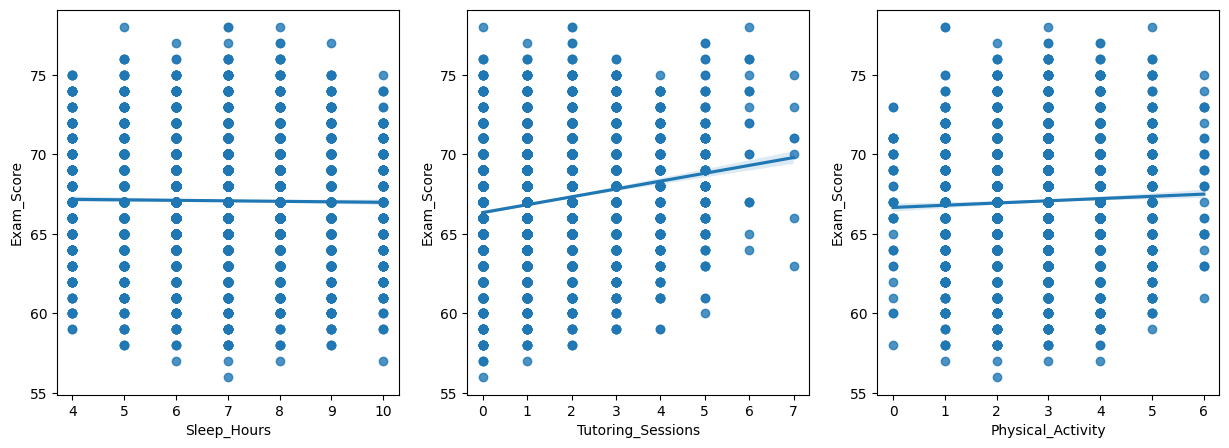

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, column in enumerate(['Sleep_Hours', 'Tutoring_Sessions', 'Physical_Activity']):
    sns.regplot(data=filtered_df, x=column, y='Exam_Score', ax=ax[i])

In [11]:
anova_stat = []
p_value = []
significant = []

for column in categorical_columns:
    groups = [filtered_df[filtered_df[column] == category]['Exam_Score'] for category in filtered_df[column].unique()]
    f_stat, p = f_oneway(*groups)

    anova_stat.append(f_stat)
    p_value.append(p)

    if p < 0.05:
        significant.append(True)
    else:
        significant.append(False)

pd.DataFrame({'Categorical Column': categorical_columns, 'F-Statistic': anova_stat, 'P-Value': p_value, 'Significant': significant}).to_csv('categorical_significances.csv', index=False)

In [12]:
quantitative_df = df.drop(columns=categorical_columns)

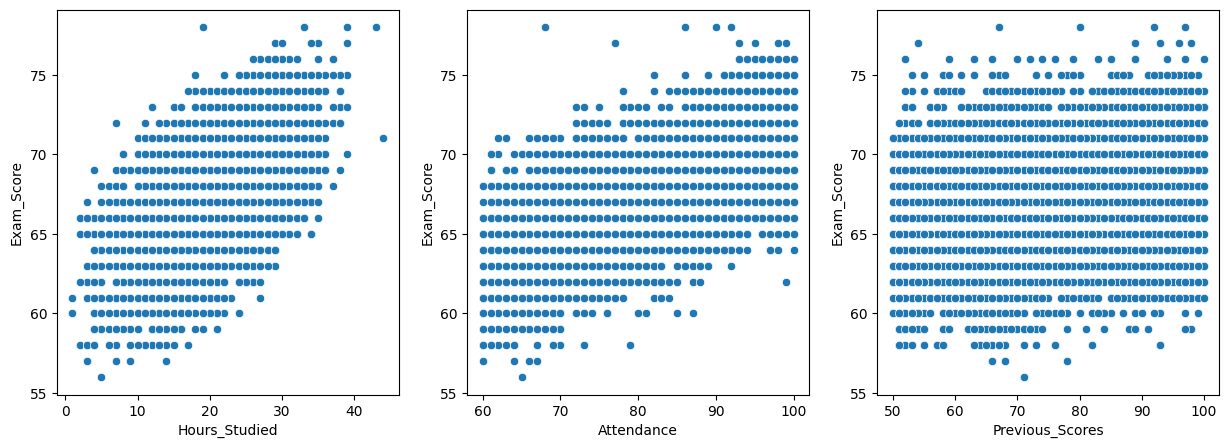

In [13]:
quantitative_columns = quantitative_df.columns.tolist()

fig, ax = plt.subplots(1,3, figsize=(15,5))

for i, column in enumerate(['Hours_Studied', 'Attendance', 'Previous_Scores']):
    sns.scatterplot(data=filtered_df, x=column, y='Exam_Score', ax=ax[i])

In [14]:
from scipy.stats import pearsonr

correlation = []
p_value = []
significant = []

for column in quantitative_df.columns:
    if column == 'Exam_Score':
        continue
    r, p = pearsonr(df['Exam_Score'], df[column])
    correlation.append(r)

    p_value.append(p)

    if p < 0.05:
        significant.append(True)
    else:
        significant.append(False)

pd.DataFrame(
    {'Feature': quantitative_df.columns[:-1], 'Pearson Corr Coeff': correlation, 'P-Value': p_value, 'Significant': significant}
).to_csv('correlations.csv', index=False)

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse_output=False)

categorical_columns = list(set(categorical_columns) - {'School_Type', 'Gender', 'Sleep_Hours'})
quantitative_columns = list(set(quantitative_columns) - {'Exam_Score'})

train_df = filtered_df.copy().drop(columns=['Exam_Score', 'Sleep_Hours', 'School_Type', 'Gender'])
categorical_df = train_df[categorical_columns]
continuous_df = train_df[quantitative_columns]

one_hot_encoded = one_hot_encoder.fit_transform(categorical_df)
one_hot_df = pd.DataFrame(one_hot_encoded, columns=list(one_hot_encoder.get_feature_names_out(categorical_columns)))

concat_df = pd.concat([one_hot_df, continuous_df.reset_index(drop=True)], axis=1)

X = concat_df
y = filtered_df['Exam_Score']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
# Create and train the linear regression model
model = LinearRegression()
pca = PCA(n_components=1)

model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 0.26859601891559104
R-squared: 0.9908145271933135


In [17]:
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

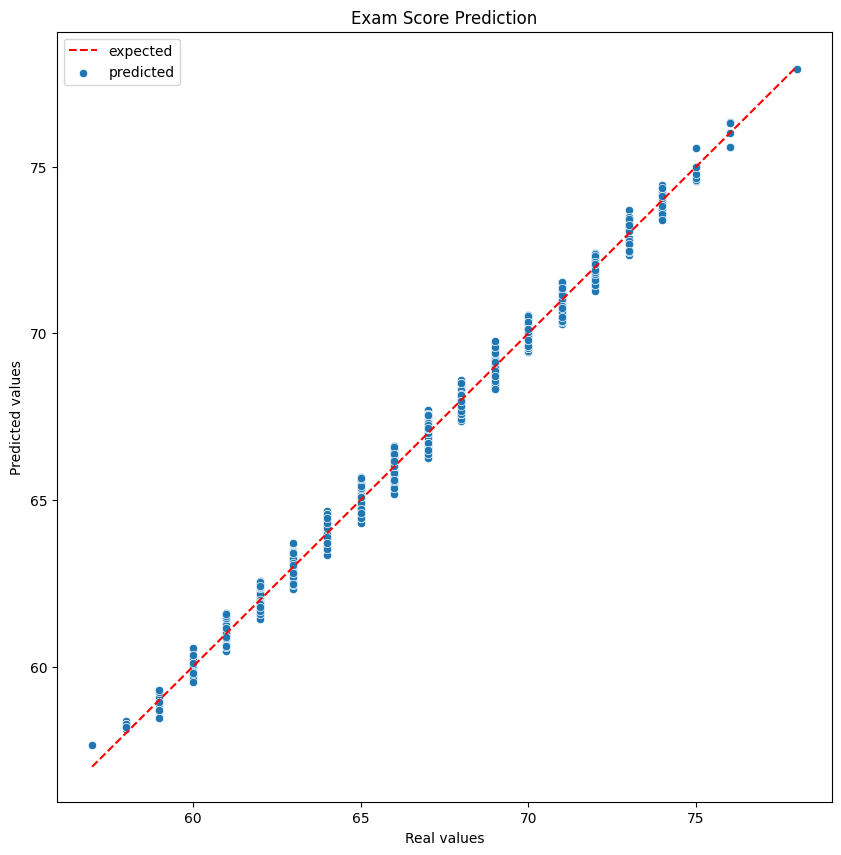

In [18]:
# Plot real vs predicted values

plt.figure(figsize=(10, 10))

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='expected')
sns.scatterplot(x=np.squeeze(y_test), y=np.squeeze(y_pred), label='predicted')

plt.xlabel('Real values')
plt.ylabel('Predicted values')
plt.legend()
plt.title('Exam Score Prediction')
plt.show()